# CCLM2 Nature Futures
-----------------
Produces Fig. 8 and supplementary Figs. 10-14

In [1]:
import warnings
import os
import ast
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm import tqdm

# Statistics and ML packages
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupShuffleSplit

In [2]:
%load_ext autoreload
%autoreload 2

# Custom settings and functions
from settings import *
from plotting import *
from func_calc import *
from func_stats import *
from func_plots import *

# Mute warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
set_plot_param()
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'facecolor': '1'} # display figues as exported to PDF without 'tight'

# Settings

In [3]:
# Save to
os.makedirs('Figures/ridge', exist_ok=True)
os.makedirs(dpath_proc + 'ridgeOutputs/', exist_ok=True)

In [4]:
# Mask of potentially modified grid cells, based on EUNIS habitat mapping area (EU+)
eunis = xr.open_dataarray(dpath_proc + 'eunis_mask_repr.nc')

# Region mask
mask_2D = xr.open_dataarray(dpath_proc + 'regionmask_2D_Dou.nc')
mask_3D = xr.open_dataarray(dpath_proc + 'regionmask_3D_Dou.nc')
region_dict = {0: 'North', 1: 'West', 2: 'East', 3: 'South'}

# Combine subregins and EU+ into one mask
eunis_mask = xr.where(eunis==1, True, False).rename('EU+') # convert to a boolean mask
eunis_mask = eunis_mask.expand_dims('region').assign_coords(region=['EU+']) # add region dimension
mask_3D_eu = xr.concat([eunis_mask, mask_3D], dim='region') # combine to joint mask

In [5]:
# SSP1 reference
file = 'surf.nc'
var_surf = ['PCT_TREE_NL','PCT_TREE_BL','PCT_SHRUB','PCT_GRASS','PCT_CROP','PCT_CROP_rain','PCT_CROP_irr','PCT_BARE']
surf_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
surf_ssp1 = split_crop(surf_ssp1) # split rainfed and irrigated crop
veg_mask = (surf_ssp1.PCT_NATVEG+surf_ssp1.PCT_CROP)>0 # save vegetation mask
area = surf_ssp1.AREA # save grid cell area for weighting
surf_ssp1 = surf_ssp1[var_surf]

file = 'cclm2_seasonal-climatology.nc'
var_clim = ['T_2M','TSKIN','PRECIP','ALBEDO','z0m','EF','LH','SH','SWdown','LWdown']
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[var_clim]

# Functions

In [6]:
# Define blocks for spatial block bootstrapping
def spatial_blocks(lats, lons, blockdim=5):
    lat_cells = len(lats)
    lon_cells = len(lons)
    
    # Initialize a DataArray with NaN values
    data = np.empty((lat_cells, lon_cells), dtype=float)
    data.fill(np.nan)
    
    # Fill blocks of blockdim x blockdim cells with numbers (starting with 1 in the lower left corner)
    number = 1
    for lat in range(0, lat_cells, blockdim):
        for lon in range(0, lon_cells, blockdim):
            # Fill the block with the current number
            data[lat:lat + blockdim, lon:lon + blockdim] = number
            number += 1
    
    # Create the DataArray
    da = xr.DataArray(data,
                      dims=["lat", "lon"],
                      coords={"lat": np.arange(lat_cells),
                              "lon": np.arange(lon_cells)})
    
    # Set coordinates
    da.coords['lat'] = lats
    da.coords['lon'] = lons
    
    return da

In [7]:
# Data preparation
# Prepare scenario data
def prep_scenario(case, season, blockdim=None):
    file = 'cclm2_seasonal-climatology.nc'
    dds = xr.open_dataset(dpath_proc + f'cclm2_EUR11_FB_{case}/' + file)[var_clim] - ds_ssp1
    dds = dds.sel(season=season, drop=True) # select season   
    dds = dds.assign(region=mask_2D) # assign subregions as variable
    
    file = 'surf.nc'
    surf = xr.open_dataset(dpath_proc + f'cclm2_EUR11_FB_{case}/' + file)
    surf = split_crop(surf) # split rainfed and irrigated crop
    dds[var_surf] = surf[var_surf] - surf_ssp1 # add selected surface changes
    dds['pct_change'] = surf.pct_change
    #dds = masked(dds, noise=10**-5, other=0) # set very small differences to zero 

    dds['Temp'] = ds_ssp1['T_2M'].sel(season=season, drop=True) # add absolute T2m and Precip in reference data
    dds['Prec'] = ds_ssp1['PRECIP'].sel(season=season, drop=True)
    #dds['Temp'] = ds_forcing['T_2M'] # add absolute T2m and Precip in forcing data
    #dds['Prec'] = ds_forcing['PRECIP']
    dds['area'] = area # grid cell area for weighting
    if blockdim:
        dds['block'] = spatial_blocks(dds.lat, dds.lon, blockdim) # define blocks for spatial block bootstrapping

    # Rename variables
    name_dict = {'T_2M': 'T2m', 'TSKIN': 'Tskin', 'ALBEDO': 'Albedo', 'z0m': 'Roughness', 
                 'PCT_TREE_NL': 'TreeNL', 'PCT_TREE_BL': 'TreeBL', 'PCT_SHRUB': 'Shrub', 'PCT_GRASS': 'Grass', 'PCT_CROP': 'Crop', 'PCT_CROP_rain': 'CropR', 'PCT_CROP_irr': 'CropI', 'PCT_BARE': 'Bare'}
    dds = dds.rename(name_dict)

    dds = dds.where(eunis==1) # mask
    df = dds.to_dataframe().dropna(how='all', subset=['T2m']) # drop nans among all variables
    df = df.replace({'region': region_dict}) # replace region indices by names  
    if blockdim:
        df = df.reset_index().set_index(['lat','lon','region','block','area'])
    else:
        df = df.reset_index().set_index(['lat','lon','region','area'])
    return df

In [8]:
# Calculate net transitions
def calc_transitions(df, types):
    data = df[types].reset_index(drop=True) # drop index for faster processing
    data = data.round(4).values # round for faster processing
    n_types = len(types)
    
    # Generate all possible transitions (excluding self-transitions)
    transition_labels = [f"{types[i]}_to_{types[j]}" for i in range(n_types) for j in range(n_types) if i != j]
    transition_df = pd.DataFrame(0, index=range(len(data)), columns=transition_labels)
    
    # Fill transition matrix per grid cell, using greedy filling from the most to the least gaining vegetation types
    # Gains are filled using the available losses in descending order (i.e., largest initial and largest remaining after recalculation)  
    for row_idx, row in enumerate(data):
        gains = [(i, row[i]) for i in range(n_types) if row[i] > 0]
        losses = [(i, -row[i]) for i in range(n_types) if row[i] < 0]
        gains.sort(key=lambda x: -x[1])
        losses.sort(key=lambda x: -x[1])
        for gain_idx, gain_amt in gains:
            for i in range(len(losses)):
                loss_idx, loss_amt = losses[i]
                if loss_amt == 0:
                    continue
                transfer = min(gain_amt, loss_amt)
                label = f"{types[loss_idx]}_to_{types[gain_idx]}"
                transition_df.at[row_idx, label] += transfer
                gain_amt -= transfer
                losses[i] = (loss_idx, loss_amt - transfer)
                if gain_amt == 0:
                    break

    # Compute net transitions with dominant direction as label
    net_transition_dict = {}
    for i in range(n_types):
        for j in range(i + 1, n_types):
            forward = f"{types[i]}_to_{types[j]}"
            reverse = f"{types[j]}_to_{types[i]}"
            forward_sum = transition_df.get(forward, pd.Series(0)).sum()
            reverse_sum = transition_df.get(reverse, pd.Series(0)).sum()
            if forward_sum >= reverse_sum:
                net_label = forward
                net_values = transition_df.get(forward, pd.Series(0)) - transition_df.get(reverse, pd.Series(0))
            else:
                net_label = reverse
                net_values = transition_df.get(reverse, pd.Series(0)) - transition_df.get(forward, pd.Series(0))
            net_transition_dict[net_label] = net_values
    net_transition_df = pd.DataFrame(net_transition_dict).set_index(df.index)
    
    return net_transition_df

In [9]:
# Prepare feature matrix for ridge
def prep_ridge_data(case, season, blockdim, aux, model):
    # Prepare data
    df = prep_scenario(case=case, season=season, blockdim=blockdim)
    
    # Calculate net transitions and drop zero transitions
    types = ['TreeNL', 'TreeBL', 'Shrub', 'Grass', 'CropR', 'CropI', 'Bare']
    #types = ['TreeNL', 'TreeBL', 'Shrub', 'Grass', 'Crop', 'Bare']
    trans = calc_transitions(df, types)
    trans_zero = list(trans.columns[trans.sum()==0].values)
    trans = trans.drop(columns=trans_zero)
    transition_types = list(trans.columns.values)
    #print("Dropped transitions: ", trans_zero)
    
    # Combine target, aux and transitions
    df = df[['T2m', 'Tskin', 'Albedo', 'Roughness', 'EF', 'Temp', 'Prec', 'pct_change']].join(trans)
    df = df.reset_index()
    
    # Select features and auxiliaries
    if 'Latitude' in aux:
        df[['Latitude','Longitude']] = df[['lat','lon']].values # rename to avoid same names as xarray coords
    features = transition_types + aux 
    
    # Combined dataframe for EU+ and subregions
    df_eu = df.copy() # data.loc[~data.region.isna()] # exclude cells that are not in any subregion
    df_eu['region'] = 'EU+'
    data = pd.concat([df_eu, df.loc[df.region.notna()]])
    return [data, features]

In [10]:
# Train and test split
def gen_matrix(data, target, features, remove_outliers=True, seed=0, test_size=0.25):
    df = data[[target] + features]
    df = df.dropna(how='all', subset=[target])

    # Outlier removal: set a threshold on the standard scores (z-score) of the target variable
    # e.g. setting it to 2, we expect to waste 2∗2.3=4.6% of the data, .i.e., 2.3% above and 2.3% below 2 sd.
    if remove_outliers is True:
        zscore = (df[target] - df[target].mean()) / df[target].std()
        idx = (np.abs(zscore) > 2)
        df = df[~idx]
    
    X = df.loc[:, features] # feature matrix
    y = df.loc[:, target] # target variable
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed) # random_state=2 predicts a terrible outlier
    X_train = pd.DataFrame(data=X_train, columns=features) # Convert back to pandas dataframe for easier indexing
    X_test = pd.DataFrame(data=X_test, columns=features)
    
    # # Standardise (if not using a pipeline) - preferred because pipe does not pass on feature names, problem for permutation feature importance
    # scaler = StandardScaler().fit(X_train[features]) # compute the mean and std to be used for later scaling
    # X_train = scaler.transform(X_train[features]) # perform standardization by centering and scaling
    # X_test = scaler.transform(X_test[features])
    # X_train = pd.DataFrame(data=X_train, columns=features) # Convert back to pandas dataframe for easier indexing
    # X_test = pd.DataFrame(data=X_test, columns=features)

    return X_train, X_test, y_train, y_test

# Train and test split while preserving the spatial blocks
def gen_matrix_spatial(data, target, features, remove_outliers=True, seed=0, test_size=0.25):
    df = data[[target] + features + ['block','area']]
    df = df.dropna(how='all', subset=[target])
    
    # Outlier removal: set a threshold on the standard scores (z-score) of the target variable
    # e.g. setting it to 2, we expect to waste 2∗2.3=4.6% of the data, .i.e., 2.3% above and 2.3% below 2 sd.
    if remove_outliers is True:
        zscore = (df[target] - df[target].mean()) / df[target].std()
        idx = (np.abs(zscore) > 2)
        df = df[~idx]
    
    X = df.loc[:, features] # feature matrix
    y = df.loc[:, target] # target variable
    groups = df.block
    
    # Cross-validation splitter that provides randomized train/test indices to split data according to groups (here spatial blocks)
    # Test size refers to groups and not to samples (!)
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_idx, test_idx = next(gss.split(X, y, groups))
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

    return X_train, X_test, y_train, y_test

In [11]:
# Function to evaluate and store model performance
def model_performance(pipe, X_train, X_test, y_train, y_test, alpha=np.nan):    
    # Predictions for train and test data
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # Calculate scores and store
    results = {"alpha": alpha,
               "MAE_train": MAE(y_train, y_pred_train).round(3),
               "MAE_test": MAE(y_test, y_pred_test).round(3),
               #"RMSE_train": MSE(y_train, y_pred_train, squared=False).round(3),
               #"RMSE_test": MSE(y_test, y_pred_test, squared=False).round(3),
               "R2_train": pipe.score(X_train, y_train).round(3), # R2 measured on the training set (“training error”)
               "R2_test": pipe.score(X_test, y_test).round(3) # R2 measured on the test set (“final error”)
              }   
    return results

def model_performance_single(pipe, X_train, X_test, y_train, y_test, alpha=np.nan): 
    # Predictions for train and test data
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # Calculate scores and store
    results = {"alpha": alpha,
               "MAE_train": MAE(y_train, y_pred_train).round(3),
               "MAE_test": MAE(y_test, y_pred_test).round(3),
               "R2_train": pipe.score(X_train, y_train).round(3), # R2 measured on the training set (“training error”)
               "R2_test": pipe.score(X_test, y_test).round(3) # R2 measured on the test set (“final error”)}
              }
    return pd.Series(results)

In [12]:
# Compute confidence interval of the mean for a dataframe (variables in columns)
def confidence_interval(df_in, group_dim=None, confidence=0.95):
    from scipy import stats
    df = df_in.dropna() # avoid counting nan for n
    if group_dim:
        mean = df.groupby(group_dim).mean()
        std = df.groupby(group_dim).std()
        n = df.groupby(group_dim).size()[0] # assumes same number of elements within each group (here 15 years)
    else:
        mean = df.mean()
        std = df.std()
        n = len(df)
    ci_upper = std/np.sqrt(n) * stats.t.ppf(1-(1-confidence)/2, n-1)
    return ci_upper

# Compute confidence interval based on bootstrap percentiles, return df of lists [lower, upper]
def confidence_interval_percentiles(df, group_dim=None, confidence=0.95):
    p_lower = np.round((1-confidence)/2, 4) # lower percentile
    p_upper = np.round(1-(1-confidence)/2, 4) # upper percentile
    if group_dim is not None:
        percentiles = df.groupby('region').quantile([p_lower,p_upper]) # percentiles
        ci = percentiles - df.groupby('region').mean() # ci as deviation from the mean
        ci = ci.reset_index() # reshape and combine quantiles into lists
        result = ci.groupby(['region']).agg(lambda x: list(x))
        result = result.drop(columns='level_1')
    else:
        ci_lists = {col: (df[col].quantile([p_lower,p_upper])-df[col].mean()).tolist() for col in df.columns[1:]} # compute ci for each column
        result = pd.DataFrame([ci_lists])
    return result

In [13]:
# Feature importance per region
def ridge_reg_cv(data, target, features, interaction=1, runs=30, alpha_range=(0.1,20), test_size=0.25, figsize=(7,2.5), xytext=(0.02,0.72), importance_threshold=0, importance_length=None,
                hspace=0.1, wspace=0.1, left=0.1, right=0.1, bottom=0.1, top=0.1):

    fig, axes = plt.subplots(2,3, figsize=figsize)
    axes = axes.flatten()
    
    # Subplot per region
    for reg,ax in zip(['EU+', 'North', 'West', 'East', 'South'], axes):
        if reg == 'EU+':
            df = data
        else:
            df = data.loc[data.region == reg]
    
        results = [] # store performance results
        coef = [] # store coefficients (feature importance)
    
        # Run n times to test robustness and calculate the CI
        for run in range(runs):
            X_train, X_test, y_train, y_test = gen_matrix_spatial(df, target, features, remove_outliers=True, seed=run, test_size=test_size)
            
            # Ridge without interaction
            alpha_min, alpha_max = alpha_range
            alphas = np.linspace(alpha_min, alpha_max, 100)
            pipe = make_pipeline(
                PolynomialFeatures(degree=interaction, interaction_only=True, include_bias=False), # include_bias=False removes intercept (will be generated by regression)
                StandardScaler(),
                RidgeCV(alphas=alphas))
            pipe.fit(X_train, y_train)
            ridge = pipe.named_steps['ridgecv'] # extract ridgecv part from the pipeline
            features_poly = pipe.named_steps['polynomialfeatures'].get_feature_names_out(input_features=features)
        
            # Model performance (appended)
            results = model_performance(results, pipe, X_train, X_test, y_train, y_test, ridge.alpha_)
            
            # Feature importance
            coef.append(ridge.coef_)
    
        # Region summary over the runs
        df_results = pd.DataFrame(results)
        df_coef = pd.DataFrame(np.row_stack(coef), columns=features_poly)
        
        # Feature importance with regression coefficient (conditional dependencies = dependencies between a feature and the target when all other features remain constant; not marginal!)
        feature_importance = df_coef.mean().sort_values(ascending=True)
        feature_importance = feature_importance.loc[np.abs(feature_importance)>importance_threshold] # data to plot
        if importance_length:
            feature_importance = feature_importance.loc[np.abs(feature_importance).sort_values(ascending=False)[:importance_length].index]
            feature_importance = feature_importance.sort_values(ascending=True)
        ci = confidence_interval(df_coef, confidence=0.95)[feature_importance.index]
        #std = df_coef.std()[feature_importance.index]
        
        # Plot mean importance + errorbar
        feature_importance.plot.barh(ax=ax, grid=False, width=0.5, edgecolor='black', linewidth=0.3, xerr=ci, capsize=0);
        widths = np.array([bar.get_width() for bar in ax.containers[1]])
        divnorm = mpl.colors.TwoSlopeNorm(vmin=widths.min(), vcenter=0, vmax=max(widths.max(), 1e-05)) # max has to be >0; set to small pos number if max is negative 
        div_colors = plt.cm.RdBu_r(divnorm(widths))
        for bar, color in zip(ax.containers[1], div_colors):
            bar.set_facecolor(color)
        ax.xaxis.grid(True)
        ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax.set_title(reg + ' (n= {:,})'.format(len(df)))
        new_labels = [label.get_text().replace('_to_', ' to ') for label in ax.get_yticklabels()] # modify tick labels
        ax.set_yticklabels(new_labels)
    
        # Annotation box
        performance = df_results.mean()
        alpha = 'α        {:.1f}'.format(performance.alpha)
        mae = 'MAE  {:.2f}  ({:.2f})'.format(performance.MAE_test, performance.MAE_train)
        r2 = 'R²      {:.2f}  ({:.2f})'.format(performance.R2_test, performance.R2_train)
        text = f"{alpha} \n{mae} \n{r2}"
        bbox_props = dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black", linewidth=0.5)
        ax.annotate(text, xycoords='axes fraction', xy=(0, 0), xytext=xytext, bbox=bbox_props, fontsize=5);

    fig.subplots_adjust(hspace=hspace, wspace=wspace, left=left, right=right, bottom=bottom, top=top)
    axes[-1].remove()

In [14]:
# Run multi-region ridge with spatial block bootstrap
regions = ['North','West','East','South', 'EU+']
subregions = ['North','West','East','South']

def ridge_pipeline(case, target, data, features, model, runs, test_size, interaction):
    # Store results of runs
    result = [] # performance results
    intercept = [] # intercept in non-standardised space
    coef = [] # unstandardised coefficients (sensitivity, per unit (%) change)
    contrib = [] # feature contribution in non-standardised space (per feature, spatial mean)
    prediction = [] # predicted dT (intercept + contrib, spatial mean)
    
    # Store results of feature contribution per region
    contribSum_df = pd.DataFrame()
    contrib_df = pd.DataFrame()

    for i in tqdm(regions):
        df = data.query("region == @i")
        aux_mean = (df[aux].mul(df.area, axis=0).sum(axis=0)).div(df.area.sum(), axis=0) # weighted spatial average
        df.loc[:,aux] = 100 * (df[aux]-aux_mean)/aux_mean # include as anomaly in %, affects the non-standardised intercept and the sensitivity (now also in %)
        
        intercept_reg = [] # regional intercept
        contrib_reg = [] # individual feature contributions per grid cell
        contribSum_reg = [] # total feature contribution (sum over features, per grid cell)
        
        # Run n times to test robustness
        for run in range(runs):
            X_train, X_test, y_train, y_test = gen_matrix_spatial(df, target, features, seed=run, test_size=test_size)
            
            # Ridge without interaction
            #alpha_min, alpha_max = alpha_range
            #alphas = np.linspace(alpha_min, alpha_max, 100)
            alphas = np.logspace(-1, 3.3, 50)
            pipe = make_pipeline(
                PolynomialFeatures(degree=interaction, interaction_only=True, include_bias=False), # include_bias=False removes intercept (will be generated by regression)
                StandardScaler(),
                RidgeCV(alphas=alphas, fit_intercept=True))
            pipe.fit(X_train, y_train)
            ridge = pipe.named_steps['ridgecv'] # extract ridgecv part from the pipeline
            scaler = pipe.named_steps['standardscaler']
        
            # Save results
            result.append(model_performance(pipe, X_train, X_test, y_train, y_test, ridge.alpha_)) # model performance
            #fi.append(ridge.coef_) # feature importance (standardised space)
            coef.append(ridge.coef_/scaler.scale_) # non-standardised coefficients
            intercept.append(ridge.intercept_ - np.sum(ridge.coef_*(scaler.mean_/scaler.scale_))) # intercept (non-standardised space) when original features are zero
            intercept_reg.append(ridge.intercept_ - np.sum(ridge.coef_*(scaler.mean_/scaler.scale_)))
            # Feature contribution (non-standardised space)
            contributions = pd.DataFrame(data=df[features], columns=features).mul(ridge.coef_/scaler.scale_, axis=1) # feature contributions per grid cell, from unstandardised features
            contrib_reg.append(contributions) # individual feature contributions per grid cell
            contribSum_reg.append(contributions.sum(axis=1)) # contribution of all features per grid cell
            contrib.append(contributions.mul(df.area, axis=0).sum(axis=0) / df.area.sum(axis=0)) # contribution per feature, weighted spatial average        
            # t prediction, weighted spatial average across grid cells (gives the same as results calculated from non-standardised intercept and coefs)
            prediction.append((pipe.predict(df[features])*df.area).sum(axis=0)/df.area.sum(axis=0))

        # Per region, save mean results of contribSum across runs
        contribSum_reg = pd.DataFrame(pd.DataFrame(contribSum_reg).mean().rename('contrib')) # mean over runs
        contribSum_reg['intercept'] = np.mean(intercept_reg) 
        contribSum_reg[['lat','lon','region','area',target]] = df[['lat','lon','region','area',target]] #.reset_index(drop=True)
        contribSum_df = pd.concat([contribSum_df,contribSum_reg])
        # Per region, save mean results of contributions across runs
        contrib_reg = pd.concat(contrib_reg, keys=range(runs)) # stack all dfs in the list into one big df
        contrib_reg = contrib_reg.groupby(level=1).mean() # mean across the runs per region
        contrib_reg[['lat','lon','region']] = df[['lat','lon','region']] #.reset_index(drop=True)
        contrib_df = pd.concat([contrib_df,contrib_reg])
    
    # Collect feature specific results
    reglabel = np.repeat(regions, runs)
    # Sensitivity (non-standardised coefficient)
    df_coef = pd.DataFrame(np.row_stack(coef), columns=features)
    df_coef.insert(0, column='region', value=reglabel)
    coef_mean = df_coef.groupby('region').mean()
    coef_ci = confidence_interval_percentiles(df_coef, group_dim='region', confidence=0.95)
    # Feature contribution (coef*delta)
    df_contrib = pd.DataFrame(np.row_stack(contrib), columns=features)
    df_contrib.insert(0, column='region', value=reglabel)
    contrib_mean = df_contrib.groupby('region').mean()
    contrib_ci = confidence_interval_percentiles(df_contrib, group_dim='region', confidence=0.95)
    
    # Collect results per fit
    df_result = pd.DataFrame(result)
    df_result.insert(0, column='region', value=reglabel)
    df_result['intercept'] = intercept
    df_result['contrib'] = df_contrib[features].sum(axis=1)
    df_result['prediction'] = prediction # predicted dt
    # Actual dt
    dt_reg = (data[target]*data['area']).groupby(data.region).sum()/data['area'].groupby(data.region).sum()
    dt_reg = dt_reg.reset_index(name='dT')
    df_result = df_result.merge(dt_reg, on='region')
    df_result['bias'] = df_result.prediction - df_result.dT # difference
    df_result['frac_contrib'] = (100*(df_result.contrib/df_result.prediction)).round(1)
    df_result['frac_bias'] = (100*(df_result.bias/df_result.prediction)).round(1)
    # Mean across runs
    #result_mean = df_result.groupby('region').mean()

    # Calculate contributions for Europe as the weighted average of subregions
    #reg_area = data.area.groupby(data.region).sum()[subregions]
    #contrib_mean.loc['Regional',:] = contrib_mean.loc[subregions].mul(reg_area, axis=0).sum(axis=0)/reg_area.sum()
    #result_mean.loc['Regional',:] = result_mean.loc[subregions].mul(reg_area, axis=0).sum(axis=0)/reg_area.sum()
    
    # Save data for target and case
    data.to_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_data.csv')
    df_result.to_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_result.csv')
    coef_mean.to_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_coefmean.csv')
    coef_ci.to_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_coefci.csv')
    contrib_mean.to_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_contribmean.csv')
    contrib_ci.to_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_contribci.csv')

# Ridge regression

**Steps**  
1) Target and feature selection
2) Feature engineering (e.g. generate polynoms/interactions, encode categorical/dummy variables)
3) Split into train/test sets (done by pipeline)      
4) Standardize numerical features (=scaling): AFTER data splitting and only from training data (mean, std) to avoid data leakage (ensured by pipeline); AFTER generating PolynomialFeatures (loss of signal, making random negatives), i.e. the standardized interaction term should be the standardized version of the product of the two original variables, not the product of the two standardized variables

**Multi-region ridge with spatial block bootstrap**   
All analyses in non-standardised space  
Intercept (standardised space): predicted dT when all feature means are zero (i.e., zero in standardized units) 
Coefficients (standardised space): dT per std feature change  

Intercept: dT when all original features are zero (here: no PFT changes, median lat/lon or T/P) 
Coefficients: dT per unit (% PFT change, degree lat/lon or T, mm/day P)  
Contributions: dT due to actual feature deviations from zero

## Processing

In [15]:
# General settings for all cases
season = 'JJA'
blockdim = 10
runs = 100 # 100
test_size = 0.25
interaction = 1

In [ ]:
# Run per case for Tskin and T2m as targets (takes ~2h per case and variable)
#case = 'nfn'
#case = 'nfs'
case = 'nac'
aux = []
model = 'std' # standard model, without lat/lon or T/P as additional predictors
data, features = prep_ridge_data(case=case, season=season, blockdim=blockdim, aux=aux, model=model)
for target in ['Tskin','T2m']:
    ridge_pipeline(case=case, target=target, data=data, features=features, model=model, runs=runs, test_size=test_size, interaction=interaction)

In [19]:
# Check that alpha did not hit the lower or upper limits
#print("Alpha range: ", np.min(alphas), np.max(alphas))
#print(df_result.groupby('region').alpha.describe()[['min','max']].round(1))

## Plot sensitivity and contribution

In [20]:
# Per case and region, only include transitions with sufficient data
area_lim = 0.2 # min 0.2% of area
count_lim = 20 # min 20% of grid cells

# Determine which transitions to consider based on min area and min count
def get_features_2plot(data, region, area_lim, count_lim):
    features = data.columns[data.columns.str.contains('_to_')] # include only LC transitions
    transition_area = data[features].mul(data.area, axis=0).groupby(data.region).sum().div(data.area.groupby(data.region).sum(), axis=0)
    transition_count = 100*data[features].where(abs(data[features])>0).groupby(data.region).count().div(data.area.groupby(data.region).count(), axis=0)
    features_2plot = pd.Series(features, index=features).loc[((abs(transition_area.loc[region])>area_lim) | (transition_count.loc[region]>count_lim))].tolist()
    return len(features_2plot), features_2plot

# Determine which transitions to consider based on min area and min count
def get_features_2plot_reg(data, area_lim, count_lim):
    features = data.columns[data.columns.str.contains('_to_')] # include only LC transitions
    transition_area = data[features].mul(data.area, axis=0).groupby(data.region).sum().div(data.area.groupby(data.region).sum(), axis=0)
    transition_count = 100*data[features].where(abs(data[features])>0).groupby(data.region).count().div(data.area.groupby(data.region).count(), axis=0)
    features_2plot = {}
    len_features_2plot = {}
    for region in subregions:
        features_reg = pd.Series(features, index=features).loc[((abs(transition_area.loc[region])>area_lim) | (transition_count.loc[region]>count_lim))].tolist()
        features_2plot[region] = features_reg
        len_features_2plot[region] = len(features_reg)
    return len_features_2plot, features_2plot

In [21]:
# Settings
regions = ['North','West','East','South', 'EU+']
subregions = ['North','West','East','South']
features = ['TreeNL_to_TreeBL', 'TreeNL_to_Shrub', 'TreeNL_to_Grass', 'TreeNL_to_CropR', 'CropI_to_TreeNL', 'TreeNL_to_Bare',
       'TreeBL_to_Shrub', 'TreeBL_to_Grass', 'TreeBL_to_CropR', 'CropI_to_TreeBL', 'TreeBL_to_Bare', 'Shrub_to_Grass', 'CropR_to_Shrub',
       'CropI_to_Shrub', 'Shrub_to_Bare', 'CropR_to_Grass', 'CropI_to_Grass', 'Bare_to_Grass', 'CropR_to_Bare', 'CropI_to_Bare']

### All scenarios per region (Fig. 8, Supp. Figs. 11-14)

In [22]:
reg = 'EU+' # Fig. 8
#reg = 'North' # supplementary Fig. 11
#reg = 'West' # supplementary Fig. 12
#reg = 'East' # supplementary Fig. 13
#reg = 'South' # supplementary Fig. 14
model = 'std' # standard model, without lat/lon or T/P as additional predictors
target = 'T2m'
#target = 'Tskin' # supplementary Fig. 15 (for EU+)

In [23]:
# To determine subplot height ratios, open data for all cases and check number of variables to include
data_nfn = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nfn_data.csv', index_col=0)
data_nfs = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nfs_data.csv', index_col=0)
data_nac = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nac_data.csv', index_col=0)

no_nfn, feat_nfn = get_features_2plot(data_nfn, reg, area_lim, count_lim)
no_nfs, feat_nfs = get_features_2plot(data_nfs, reg, area_lim, count_lim)
no_nac, feat_nac = get_features_2plot(data_nac, reg, area_lim, count_lim)
feat_scenarios = [feat_nfn, feat_nfs, feat_nac]

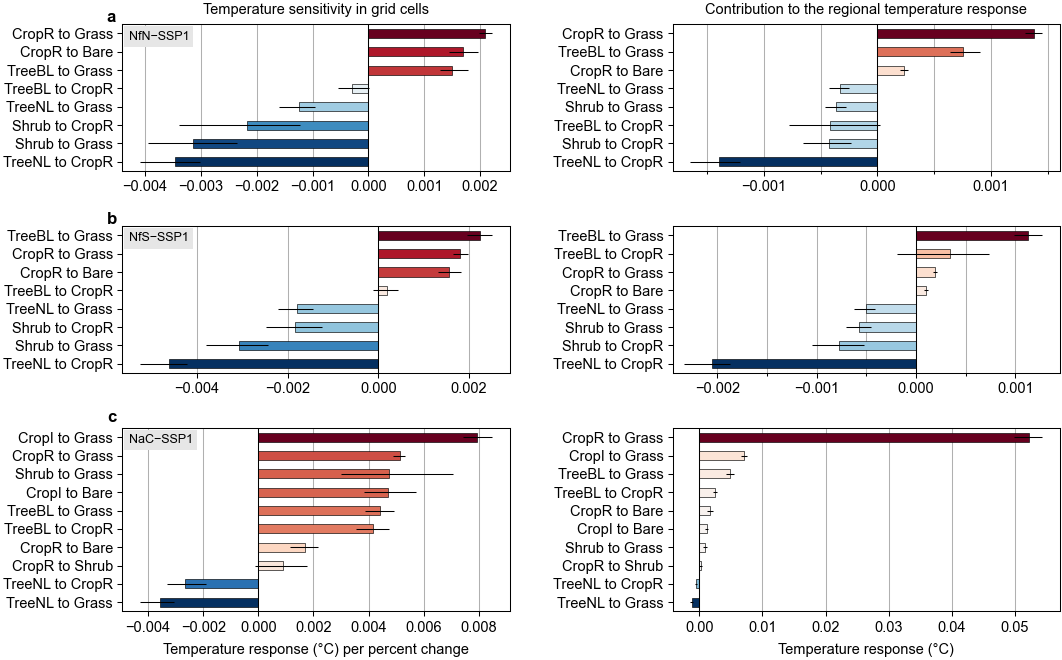

In [24]:
# Plot sensitivity and contribution, single region
height = 0.5+0.15*(no_nfn+no_nfs+no_nac) # depends on no of features
fig, axes = plt.subplots(3,2, figsize=(double_width,height), height_ratios=[no_nfn,no_nfs,no_nac])
#fig.subplots_adjust(hspace=0, wspace=0.4, left=0.12, right=0.99, bottom=0.11, top=0.95)

# Per scenario
for row, case in enumerate(['nfn','nfs','nac']):
    axesCase = axes[row,:]
    coef_mean = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_coefmean.csv', index_col=0)
    coef_ci = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_coefci.csv', index_col=0)
    contrib_mean = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_contribmean.csv', index_col=0)
    contrib_ci = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_{case}_contribci.csv', index_col=0)
    feat = feat_scenarios[row]

    # For sensitivity and contribution
    for df_mean, df_ci, ax in zip([coef_mean,contrib_mean], [coef_ci,contrib_ci], axesCase):
        df_mean_i = df_mean.loc[reg,feat].sort_values(ascending=True)
        df_ci_i = df_ci.loc[reg,feat][df_mean_i.index]
        err_lower = abs(df_ci_i.apply(ast.literal_eval).apply(lambda x: x[0])) # subtract the mean for percentiles
        err_upper = abs(df_ci_i.apply(ast.literal_eval).apply(lambda x: x[1]))
        df_mean_i.plot.barh(ax=ax, grid=False, width=0.5, edgecolor='black', linewidth=0.3, xerr=[err_lower,err_upper], capsize=0, error_kw=dict(lw=0.5), zorder=2);
        widths = np.array([bar.get_width() for bar in ax.containers[1]])
        divnorm = mpl.colors.TwoSlopeNorm(vmin=min(widths.min(), -1e-05), vcenter=0, vmax=max(widths.max(), 1e-05)) # min  has to be <0, max has to be >0; set to small number otherwise 
        div_colors = plt.cm.RdBu_r(divnorm(widths))
        for bar, color in zip(ax.containers[1], div_colors):
            bar.set_facecolor(color)
        ax.xaxis.grid(True, which='both', zorder=0)
        ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
        new_labels = [label.get_text().replace('_to_', ' to ') for label in ax.get_yticklabels()] # modify tick labels
        ax.set_yticklabels(new_labels)
axes[0,0].set_title("Temperature sensitivity in grid cells", pad=5)
axes[0,1].set_title("Contribution to the regional temperature response", pad=5)
axes[2,0].set_xlabel("Temperature response (°C) per percent change")
axes[2,1].set_xlabel("Temperature response (°C)")

# Custom formatting adjustment
if target == 'T2m' and reg == 'EU+':
    for ax in [axes[0,1], axes[1,1]]:
        ax.xaxis.set_major_locator(MultipleLocator(0.001))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    #axes[1,1].set_xticks([-0.002, -0.001, 0., 0.001])
    axes[1,1].set_xlim([-0.00245, 0.00145])

# Panel labels
for row, (label,case) in enumerate(zip(['a','b','c'],['NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1'])):
    axes[row,0].annotate(label,
                         xy=(-0.04, 1.1), xycoords='axes fraction',
                         fontsize=8, font='Arial', fontweight='bold', verticalalignment='top', horizontalalignment='left')
    axes[row,0].annotate(case,
                         xy=(0,1), xycoords='axes fraction',
                         xytext=(+3, -3), textcoords='offset points',
                         fontsize=6, font='Arial', verticalalignment='top', horizontalalignment='left',
                         bbox=dict(facecolor='0.9', edgecolor='none', pad=2.0))

plt.tight_layout(pad=0.2, h_pad=1, w_pad=3)
#plt.savefig(f'Figures/ridge/Fig8_ridge_{reg}_{model}_{target}.pdf')
plt.savefig(f'Figures/ridge/Fig8_ridge_{reg}_{model}_{target}.png')
plt.show()

## Plot coefficient stability (Supp. Fig. 10)

In [27]:
# Harmonize transitions, using the label of the direction with the higher sum across scenarios
# Net values calculated by subtracting reverse transitions when both directions are present
def harmonize_transitions(df, reference_labels=None):
    df = df.loc[df.index.str.contains('_to_')] # include only LC transitions
    harmonized = {}
    for transition in df.index:
        from_land, to_land = transition.split('_to_')
        key1 = f"{from_land}_to_{to_land}"
        key2 = f"{to_land}_to_{from_land}"
        if key1 in harmonized or key2 in harmonized: # skip if already processed
            continue
        values1 = df.loc[key1] if key1 in df.index else pd.Series([np.nan]*df.shape[1], index=df.columns)
        values2 = df.loc[key2] if key2 in df.index else pd.Series([np.nan]*df.shape[1], index=df.columns)

        # Determine direction based on reference labels if provided
        if reference_labels is not None:
            if key1 in reference_labels:
                chosen_key = key1
                net_values = values1.subtract(values2, fill_value=0)
            elif key2 in reference_labels:
                chosen_key = key2
                net_values = values2.subtract(values1, fill_value=0)
            else: # fallback if a transition is not present: sum-based decision
                sum1 = values1.sum(skipna=True)
                sum2 = values2.sum(skipna=True)
                if sum1 >= sum2:
                    chosen_key = key1
                    net_values = values1.subtract(values2, fill_value=0)
                else:
                    chosen_key = key2
                    net_values = values2.subtract(values1, fill_value=0)
        
        # Default: determine direction based on higher sum across scenarios
        else:
            sum1 = values1.sum(skipna=True)
            sum2 = values2.sum(skipna=True)
            if sum1 >= sum2:
                chosen_key = key1
                net_values = values1.subtract(values2, fill_value=0)
            else:
                chosen_key = key2
                net_values = values2.subtract(values1, fill_value=0)
        harmonized[chosen_key] = net_values

    df_harmonized = pd.DataFrame(harmonized).T
    # If provided, sort according to reference
    if reference_labels is not None:
        df_harmonized = df_harmonized.loc[reference_labels]
    # Default: sort by size
    else:
        df_harmonized['Mean'] = df_harmonized.mean(axis=1, skipna=True)
        df_harmonized = df_harmonized.sort_values(by='Mean')
        df_harmonized = df_harmonized.drop(columns='Mean')
    return df_harmonized

In [28]:
# Plot coefficient stability across scenarios
def plot_coef_stability(model, region, yerr=False, two_subregions=None, save=None):
    fig, axes = plt.subplots(1,2, figsize=(double_width, 2.5))
    for ax, target in zip(axes, ['Tskin', 'T2m']):
        data_nfn = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nfn_coefmean.csv', index_col=0)
        data_nfs = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nfs_coefmean.csv', index_col=0)
        data_nac = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nac_coefmean.csv', index_col=0)
        if yerr is True:
            ci_nfn = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nfn_coefci.csv', index_col=0)
            ci_nfs = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nfs_coefci.csv', index_col=0)
            ci_nac = pd.read_csv(dpath_proc + 'ridgeOutputs/' + f'{model}_{target}_nac_coefci.csv', index_col=0)
        case_colors = ['tab:blue','tab:orange','tab:green']    

        # Plot main region
        data = pd.concat([data_nfn.loc[region], data_nfs.loc[region], data_nac.loc[region]], axis=1, keys=['NfN','NfS','NaC'])
        data = harmonize_transitions(data)
        ref_labels = data.index.tolist() # save labels of the main plot
        if yerr is True:
            ci = pd.concat([ci_nfn.loc[region], ci_nfs.loc[region], ci_nac.loc[region]], axis=1, keys=['NfN','NfS','NaC'])
            ci = ci.applymap(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # Convert string lists to actual lists, skipping NaNs
            err_lower = ci.applymap(lambda x: x[0] if isinstance(x, list) else np.nan) # extract lower and upper bounds into new DataFrames
            err_upper = ci.applymap(lambda x: x[1] if isinstance(x, list) else np.nan)
            err_lower = abs(harmonize_transitions(err_lower, reference_labels=ref_labels))
            err_upper = abs(harmonize_transitions(err_upper, reference_labels=ref_labels))
            err_lower_upper = np.stack([err_lower.to_numpy().T, err_upper.to_numpy().T], axis=1)  # shape (3, 20), stack along new axis to get shape (3, 2, 20)
            if two_subregions is not None:
                data.plot(ax=ax, rot=90, linestyle='-', color=case_colors, yerr=err_lower_upper, capsize=0, elinewidth=0.8, legend=False)
            else:
                data.plot(ax=ax, rot=90, linestyle='-', color=case_colors, yerr=err_lower_upper, capsize=0, elinewidth=0.5, legend=False)
        else:
            data.plot(ax=ax, rot=90, linestyle='-', color=case_colors, legend=False)
        
        # Plot two subregions on top
        if two_subregions is not None:
            for reg, style in zip(two_subregions, ['-.',':']):
                data = pd.concat([data_nfn.loc[reg], data_nfs.loc[reg], data_nac.loc[reg]], axis=1, keys=['NfN','NfS','NaC'])
                data = harmonize_transitions(data, reference_labels=ref_labels)
                if yerr is True:
                    ci = pd.concat([ci_nfn.loc[reg], ci_nfs.loc[reg], ci_nac.loc[reg]], axis=1, keys=['NfN','NfS','NaC'])
                    ci = ci.applymap(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # Convert string lists to actual lists, skipping NaNs
                    err_lower = ci.applymap(lambda x: x[0] if isinstance(x, list) else np.nan) # extract lower and upper bounds into new DataFrames
                    err_upper = ci.applymap(lambda x: x[1] if isinstance(x, list) else np.nan)
                    err_lower = abs(harmonize_transitions(err_lower, reference_labels=ref_labels))
                    err_upper = abs(harmonize_transitions(err_upper, reference_labels=ref_labels))
                    err_lower_upper = np.stack([err_lower.to_numpy().T, err_upper.to_numpy().T], axis=1)
                    data.loc[ref_labels].plot(ax=ax, rot=90, linestyle=style, linewidth=0.3, color=case_colors, yerr=err_lower_upper, capsize=0, elinewidth=0.3, legend=False)
                else:
                    data.plot(ax=ax, rot=90, linestyle=style, linewidth=0.5, color=case_colors, legend=False)
       
        ax.set_title(target)
        ax.axhline(0, linewidth=0.5, color='black')
        ax.set_xticks(np.arange(0,len(data)))
        ax.set_xticklabels(ref_labels)
        new_labels = [label.get_text().replace('_to_', ' to ') for label in ax.get_xticklabels()] # modify tick labels
        ax.set_xticklabels(new_labels)

    # Legend
    if two_subregions is not None:
        handles, labels = axes[0].get_legend_handles_labels()
        h = list(handles[i] for i in [0,1,2,3,6])
        l = list(labels[i] for i in [0,1,2,3,6])
        axes[0].legend(h, ['NfN', 'NfS', 'NaC', two_subregions[0], two_subregions[1]], ncols=2, loc='upper left', frameon=False)
    else:    
        axes[0].legend(loc='upper left', frameon=False)
    plt.tight_layout(pad=0.2, w_pad=2)
    if save is not None:
        plt.savefig(f'Figures/ridge/SM-Fig10_coef_stability_{region}_{model}.png')
    plt.show()

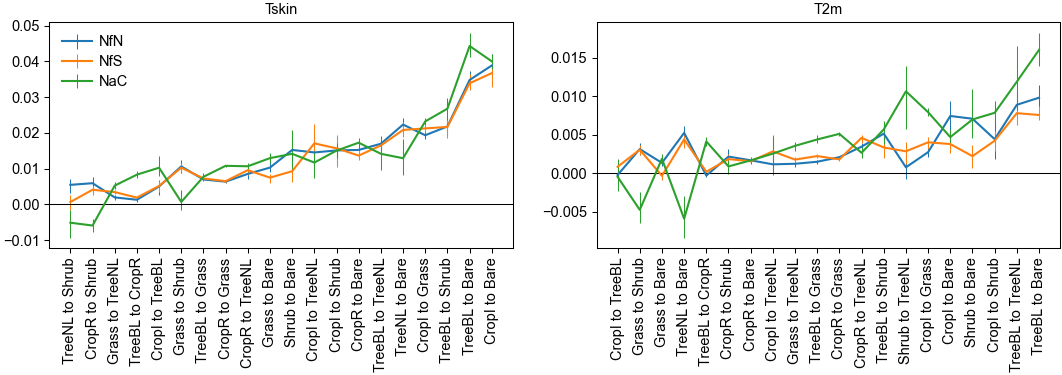

In [29]:
# Comparison across scenarios: coefficients are stable, discepancies mostly within the uncertainty range
plot_coef_stability('std', 'EU+', yerr=True, save=True)